In [119]:
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

In [120]:
df=pd.read_csv('prof.csv')

In [121]:
# Create readable time values.
df["Elapsed_s"]=pd.to_timedelta(df['Elapsed']).astype('timedelta64[s]').astype(int)
df["Submit_dt"]=pd.to_datetime(df['Submit'], format='%b %d %H:%M')
df["Start_dt"]=pd.to_datetime(df['Start'], format='%b %d %H:%M')

In [122]:
df["QueueTime_s"]=(df['Start_dt']-df['Submit_dt']).astype('timedelta64[s]').astype(int)

In [123]:
df["CPUTime_s"]=pd.to_timedelta(df['CPUTime']).astype('timedelta64[s]').astype(int)
df["MaxRSS"]=df.apply(lambda row: int(row["MaxRSS"][:-1])*1000, axis=1)
# Aggrigate
df_agg=df.groupby(["AllocCPUS","NTasks","AllocNodes","Hyperthreading"], as_index=False).agg({'Elapsed_s': ['mean', 'std'],'CPUTime_s': ['mean', 'std'],'MaxRSS': ['mean', 'std'],'QueueTime_s': ['mean', 'std']})
df_agg.columns = ["AllocCPUS","NTasks","AllocNodes","Hyperthreading",'Elapsed_s', 'Elapsed_s_std','CPUTime_s', 'CPUTime_s_std','MaxRSS', 'MaxRSS_std','QueueTime_s', 'QueueTime_s_std']
df_agg.reindex()

,AllocCPUS,NTasks,AllocNodes,Hyperthreading,Elapsed_s,Elapsed_s_std,CPUTime_s,CPUTime_s_std,MaxRSS,MaxRSS_std,QueueTime_s,QueueTime_s_std
0,4,1,1,True,2349.0,NaN,9396,NaN,4141012000,NaN,240,NaN
1,6,1,1,True,1740.0,NaN,10440,NaN,3939508000,NaN,240,NaN
2,8,1,1,True,1256.0,NaN,10048,NaN,3849668000,NaN,120,NaN
3,10,1,1,True,1072.0,NaN,10720,NaN,4016636000,NaN,0,NaN
4,12,1,1,True,1012.0,NaN,12144,NaN,4055408000,NaN,0,NaN
5,14,1,1,True,933.0,NaN,13062,NaN,4068936000,NaN,60,NaN
6,16,1,1,True,991.0,NaN,15856,NaN,4091396000,NaN,2700,NaN
7,18,1,1,True,744.0,NaN,13392,NaN,4145580000,NaN,120,NaN
8,20,1,1,True,739.0,NaN,14780,NaN,4180512000,NaN,3060,NaN
9,22,1,1,True,649.0,NaN,14278,NaN,4242864000,NaN,3060,NaN


In [179]:
#Speedup reference time.
ref_time=4406

df_agg["Speedup"]=df_agg.apply(lambda row: ref_time/row["Elapsed_s"], axis=1)
df_agg["Speedup_std"]=df_agg.apply(lambda row: row["Speedup"]*row["Elapsed_s_std"]/row["Elapsed_s"], axis=1)
df_agg["CpuEfficiency"]=df_agg.apply(lambda row: ref_time/(row["Elapsed_s"]*row["AllocCPUS"]),axis=1)

In [182]:
fig1 = px.scatter(df_agg[df_agg["AllocNodes"]==1], title="Speedup with CPUs on 1 node", x="AllocCPUS", y="Speedup", color="CpuEfficiency", error_y="Speedup_std", hover_data={"Speedup":False,"Hyperthreading":False,"AllocCPUS":False,"Elapsed_s":True,"CpuEfficiency":":.0%","QueueTime_s":True,"MaxRSS":":.2s%"})

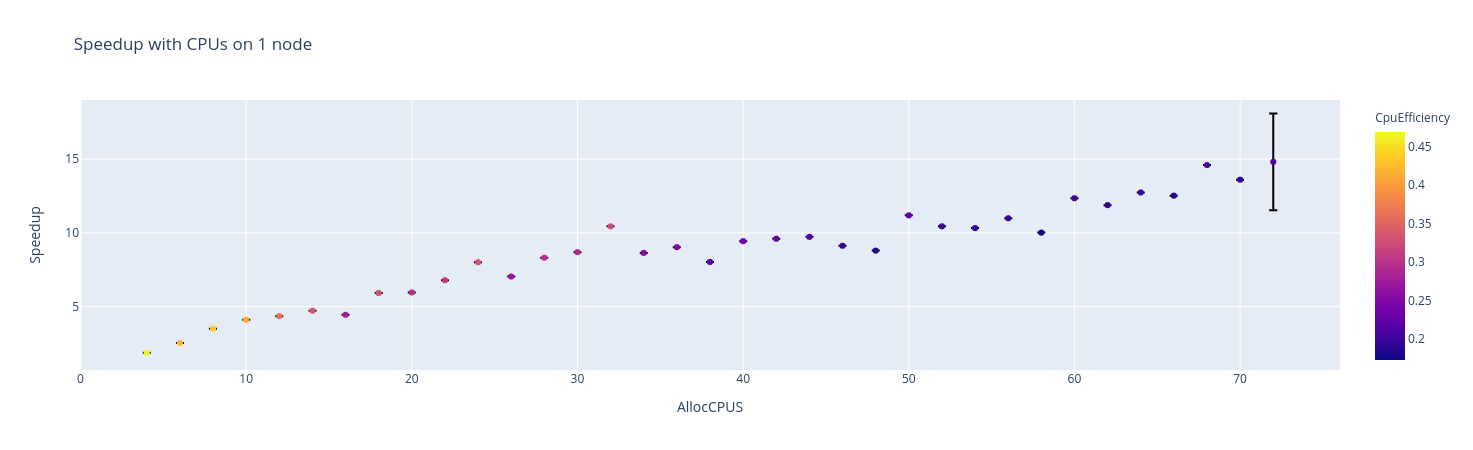

In [183]:
fig1.show()

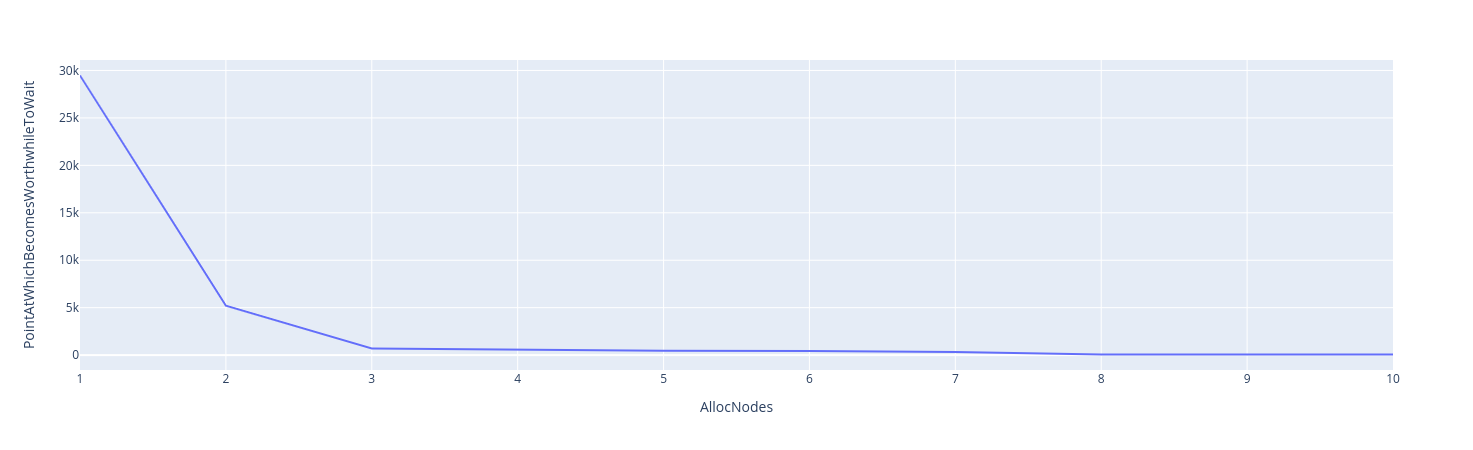

In [173]:
df_agg["LengthOfJobAtWhichItBecomesMoreTimeEfficientToSpecifyNode"]=df_agg.apply(lambda row: (row["Speedup"]*row["QueueTime_s"])/(row["Speedup"]-1), axis=1)
fig2 = px.line(df_agg[df_agg["AllocCPUS"]==72], x="AllocNodes", y="PointAtWhichBecomesWorthwhileToWait", hover_data={"Hyperthreading":False,"AllocCPUS":False,"AllocNodes":False,"CpuEfficiency":":.0%","MaxRSS":":.2s%"})
fig2.show()

In [ ]:
# fig.update_layout(
#     updatemenus=[
#         dict(
#             buttons=list([
#                 dict(
#                     args=[{'y': "MaxRSS"}],
#                     label="Memory",
#                     method="update"
#                 ),
#                 dict(
#                     args=[{'y': "speedup"}],
#                     label="Speedup",
#                     method="update"
#                 )
#             ]),
#         ),
#     ]
# )